In [ ]:
%cd drive/MyDrive/Identificacao-Defeitos-Frutas/

! git pull

/content/drive/MyDrive/Identificacao-Defeitos-Frutas
Already up to date.


In [ ]:
%tensorflow_version 2.x
%load_ext tensorboard

import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from os import path, walk
import numpy as np
import datetime

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
data_dir = path.join(path.curdir, "databases", "cajus-vermelhos")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    image_size=(512, 512),
    batch_size=12,
    seed=123)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(512, 512),
    batch_size=12,
    seed=123)

Found 120 files belonging to 3 classes.
Using 96 files for training.
Found 120 files belonging to 3 classes.
Using 24 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(512, 512, 3)))
model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.4, fill_mode="nearest"))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="swish"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="swish"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="swish"))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="swish"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="swish"))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.SpatialDropout2D(0.5))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128, activation="elu"))
model.add(tf.keras.layers.Dense(64, activation="elu"))
model.add(tf.keras.layers.Dense(32, activation="elu"))
# model.add(tf.keras.layers.Dense(16, activation="swish"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_4 (RandomFlip)   (None, 512, 512, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 124, 124, 64)     

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1)

log_dir = "./logs/cajus-vermelhos/rgb/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

In [ ]:
history = model.fit(
    train_ds,
    epochs=1000,
    validation_data=val_ds,
    callbacks=[earlyStopping, tensorboard_callback]
)

Epoch 1/1000
8/8 [==============================] - 2s 123ms/step - loss: 1.8721 - accuracy: 0.3074 - val_loss: 1.3170 - val_accuracy: 0.2083
Epoch 2/1000
8/8 [==============================] - 1s 99ms/step - loss: 1.6012 - accuracy: 0.2380 - val_loss: 1.2562 - val_accuracy: 0.1667
Epoch 3/1000
8/8 [==============================] - 1s 97ms/step - loss: 1.2884 - accuracy: 0.3929 - val_loss: 1.1825 - val_accuracy: 0.1667
Epoch 4/1000
8/8 [==============================] - 1s 98ms/step - loss: 1.2830 - accuracy: 0.3053 - val_loss: 1.1314 - val_accuracy: 0.2917
Epoch 5/1000
8/8 [==============================] - 1s 97ms/step - loss: 1.1103 - accuracy: 0.4424 - val_loss: 1.1386 - val_accuracy: 0.3750
Epoch 6/1000
8/8 [==============================] - 1s 98ms/step - loss: 1.1198 - accuracy: 0.4813 - val_loss: 1.1378 - val_accuracy: 0.2083
Epoch 7/1000
8/8 [==============================] - 1s 97ms/step - loss: 1.2021 - accuracy: 0.3509 - val_loss: 1.1618 - val_accuracy: 0.1667
Epoch 8/1000

In [ ]:
loss, acc = model.evaluate(val_ds)

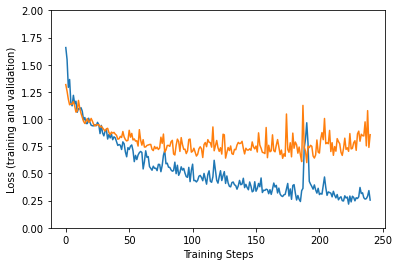

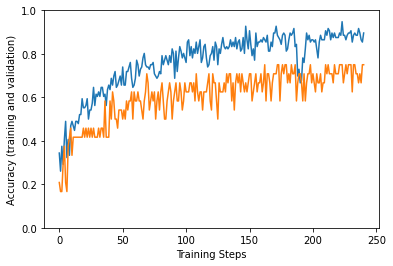

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [ ]:
! mkdir -p models/gabirobas

model.save('./models/cajus-vermelhos/rgb')

INFO:tensorflow:Assets written to: ./models/cajus-vermelhos/rgb/assets


INFO:tensorflow:Assets written to: ./models/cajus-vermelhos/rgb/assets


In [ ]:
%tensorboard --logdir ./logs/cajus-vermelhos/rgb/

In [ ]:
!tensorboard dev upload \
    --logdir ./logs/cajus-vermelhos/rgb/20210222-193928 \
    --name "cajus-vermelhos-rgb" \
    --description "cnn model on cajus-vermelhos rbg images" \
    --one_shot

2021-02-22 22:21:33.983064: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs/cajus-vermelhos/rgb/20210222-193928

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=ur

In [ ]:
loaded_model = tf.keras.models.load_model('./models/cajus-vermelhos/rgb')

In [ ]:
loaded_model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_10", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 512, 512, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "random_flip_10_input"}}, {"class_name": "RandomFlip", "config": {"name": "random_flip_10", "trainable": true, "batch_input_shape": [null, 512, 512, 3], "dtype": "float32", "mode": "horizontal_and_vertical", "seed": null}}, {"class_name": "RandomRotation", "config": {"name": "random_rotation_10", "trainable": true, "dtype": "float32", "factor": 0.4, "fill_mode": "nearest", "fill_value": 0.0, "interpolation": "bilinear", "seed": null}}, {"class_name": "Conv2D", "config": {"name": "conv2d_31", "trainable": true, "dtype": "float32", "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "swish", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "